## 用卷积神经网络处理序列

In [1]:
import os
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### 一维卷积神经网络用于IMDB情感分类任务

+ 数据预处理：

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


25000 train sequences
25000 test sequences
x_train shape: (25000, 500)
x_test shape: (25000, 500)


+ 训练一个简单的一维卷积神经网络：

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 11s 554us/step - loss: 0.8337 - acc: 0.5089 - val_loss: 0.6875 - val_acc: 0.5634
Epoch 2/10
20000/20000 [==============================] - 5s 250us/step - loss: 0.6700 - acc: 0.6402 - val_loss: 0.6642 - val_acc: 0.6588
Epoch 3/10
20000/20000 [==============================] - 5s 250us/step - loss: 0.6235 - acc: 0.7556 - val_loss: 0.6078 - val_acc: 0.7444
Epoch 4/10
20000/20000 [==============================] - 5s 251us/step - loss: 0.5256 - acc: 0.8097 - val_loss: 0.4850 - val_acc: 0.8060
Epoch 5/10
20000/20000 [==============================] - 5s 250us/step - loss: 0.4134 - acc: 0.8482 - val_loss: 0.4342 - val_acc: 0.8288
Epoch 6/10
20000/20000 [==============================] - 5s 250us/step - loss: 0.3493 - acc: 0.8675 - val_loss: 0.4148 - val_acc: 0.8350
Epoch 7/10
20000/20000 [==============================] - 5s 250us/step - loss: 0.3083 - acc: 0.8646 - val_loss: 0.4482 - 

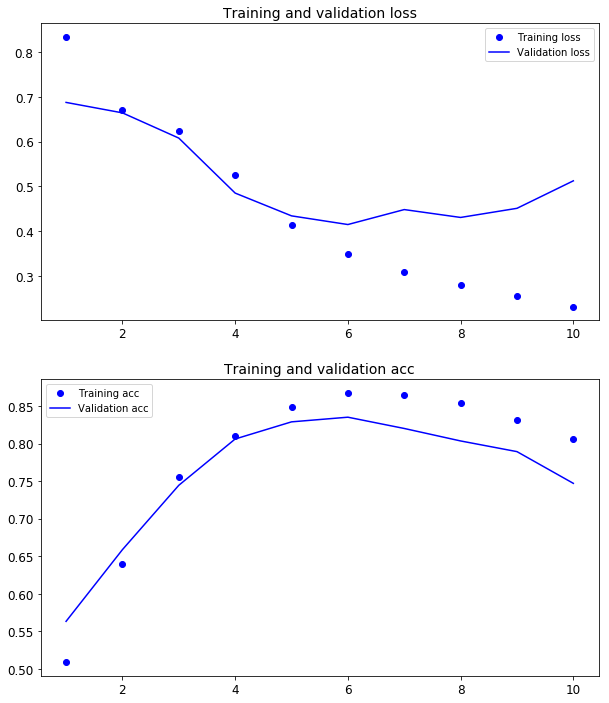

In [5]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
axes[0].set_title("Training and validation loss", fontsize=14)
axes[0].legend()

axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].set_title("Training and validation acc", fontsize=14)
axes[1].legend()

plt.show()

比LSTM精度略低，但速度很快。现在可以使用正确的轮数（6轮）重新训练这个模型，然后在测试集上运行。

### 结合CNN和RNN来处理长序列

一维卷积神经网络分别处理每个输入序列段，所以它对时间步的顺序不敏感。、

在温度预测问题（这个问题中顺序敏感性对良好的预测结果非常关键）上使用一维卷积神经网络。

In [6]:
data_dir = '/home/bingli/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [7]:
lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(headers) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [8]:
float_data.shape

(420551, 14)

In [9]:
# standardization
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
# 生成时间序列样本及其目标的生成器
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    """生成一个元组(samples, targets)，其中samples是输入数据的一个批量，targets是对应
    的目标温度数据。
    data: 浮点数据组成的原始数组
    lookback：输入数据应该包括过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    min_index和max_index：data数组中的索引，用于界定需要抽取哪些时间步
    shuffle：打乱样本，还是按顺序抽取样本
    step：数据采样的周期（单位：时间步）
    batch_size：每个批量的样本数"""
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indics = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indics]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000,
                    step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None,
                     step=step, batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4208 - val_loss: 0.4408
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3650 - val_loss: 0.4487
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3407 - val_loss: 0.4639
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.3256 - val_loss: 0.4828
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3120 - val_loss: 0.4616
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3033 - val_loss: 0.4826
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2949 - val_loss: 0.4769
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2895 - val_loss: 0.5009
Epoch 9/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2832 - val_loss: 0.4754
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.278

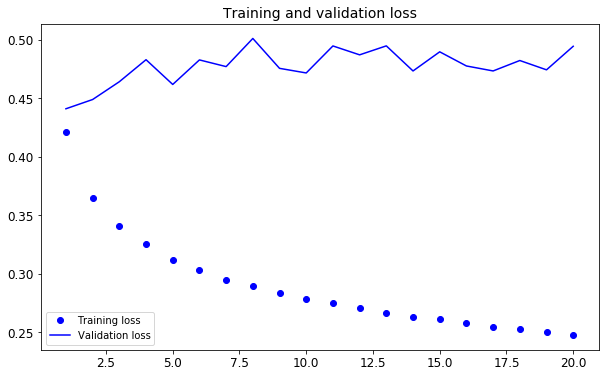

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.title('Training and validation loss', fontsize=14)
plt.show()

验证MAE在0.45-0.5，使用小型的卷积神经网络甚至无法击败基于常识的基准方法。卷积神经网络在输入时间序列的所有位置寻找模式，它并不知道所看到摸个模式的时间位置。对于这个具体的预测问题，对最新数据点的解释与对较早数据点的解释应该并不相同，所以卷积神经网络无法得到有意义的结果。卷积神经网络的这种限制对于IMDB数据来说不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句中的什么位置，它所包含的信息量都是一样的。

想要**结合卷积神经网络的速度和轻量与RNN的顺序敏感性**，一种方法是**在RNN前面使用一维卷积神经网络作为数据预处理步骤**。对于那些非常长，以至于RNN无法处理的序列（比如包含上千个时间步的序列），这种方法尤其有用。卷积神经网络可以将长的输入序列转换为高级特征组成的更短序列（下采样）。然后，提取的特征组成的这些序列成为网络中RNN的输入。

In [13]:
lookback = 720
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True,
                      step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000,
                    step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=300001, max_index=None,
                     step=step, batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 71s 143ms/step - loss: 0.3434 - val_loss: 0.2880
Epoch 2/20
500/500 [==============================] - 70s 140ms/step - loss: 0.3053 - val_loss: 0.2826
Epoch 3/20
500/500 [==============================] - 66s 133ms/step - loss: 0.2943 - val_loss: 0.2756
Epoch 4/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2845 - val_loss: 0.2762
Epoch 5/20
500/500 [==============================] - 52s 103ms/step - loss: 0.2778 - val_loss: 0.2902
Epoch 6/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2717 - val_loss: 0.2858
Epoch 7/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2666 - val_loss: 0.3002
Epoch 8/20
500/500 [==============================] - 51s 103ms/step - loss: 0.2613 - val_loss: 0.2879
Epoch 9/20
500/500 [==============================] - 53s 105ms/step - loss: 0.2576 - val_loss: 0.2787
Epoch 10/20
500/500 [==============================] - 51s 102ms/step - l

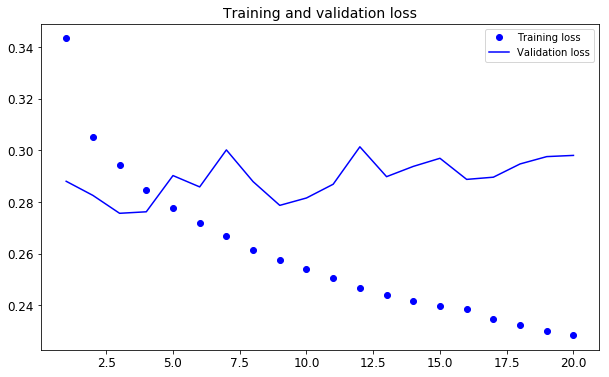

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.title('Training and validation loss', fontsize=14)
plt.show()

这种架构不如只用正则化GRU，但速度快了很多。在本例中不是很有用，但对于其他数据集可能非常重要。